In [1]:
import os
import subprocess

REPO = "pytorch-CycleGAN-and-pix2pix"
URL = "https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix"

# Clone repo safely
if not os.path.exists(REPO):
    print("⬇️ Cloning CycleGAN repository...")
    subprocess.run(["git", "clone", URL])

# Move inside repo
os.chdir(REPO)
print("📂 Now inside:", os.getcwd())

# Install required packages
print("📦 Installing CycleGAN dependencies...")
subprocess.run(["pip", "install", "dominate", "visdom"])


⬇️ Cloning CycleGAN repository...


Cloning into 'pytorch-CycleGAN-and-pix2pix'...


📂 Now inside: /home/aamena/Assessment_tcs/pytorch-CycleGAN-and-pix2pix
📦 Installing CycleGAN dependencies...


CompletedProcess(args=['pip', 'install', 'dominate', 'visdom'], returncode=0)

In [ ]:
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path

# --- CONFIG ---
DATASET_NAME = "steel_AB"
DEST_ROOT = Path("datasets") / DATASET_NAME


DOMAIN_A_SOURCE = Path("<Path_to_Domain_A_data_images>")
DOMAIN_B_SOURCE = Path("<Path_to_Domain_B_data_images>")

# --- RECOMMENDED SPLIT ---
TEST_SPLIT_SIZE = 100 
# -------------------------

# --- CLEAN START ---
if DEST_ROOT.exists():
    print(f"⚠️ Removing existing dataset folder: {DEST_ROOT}")
    # Using input() for safety, uncomment if needed for production
    # if input("Confirm deletion (y/n): ").lower() == 'y':
    shutil.rmtree(DEST_ROOT)

# Create folders
for sub in ["trainA", "trainB", "testA", "testB"]:
    (DEST_ROOT / sub).mkdir(parents=True, exist_ok=True)


def split_and_copy(src_dir: Path, dest_root: Path, test_size: int):
    """Splits all files randomly into train and test sets and copies them."""
    
    # 1. Get all relevant files
    all_files = [f for f in src_dir.iterdir() if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]
    
    if not all_files:
        print(f"❌ Error: No images found in {src_dir}")
        return

    random.shuffle(all_files) # IMPORTANT: Randomly shuffle the files

    # 2. Split into test and train
    test_files = all_files[:test_size]
    train_files = all_files[test_size:] # The rest are for training
    
    domain_name = src_dir.stem # e.g., 'images' from the path. Need to determine A or B.
    
    # Simple logic to determine A or B based on the source path name (might need adjustment)
    if 'A2' in str(src_dir):
        domain_label = 'A'
    elif 'B2' in str(src_dir):
        domain_label = 'B'
    else:
        print("Could not determine Domain label (A/B). Stopping.")
        return

    # 3. Copy Test Files
    test_dst = dest_root / f"test{domain_label}"
    print(f"➡️ Copying {len(test_files)} images → {test_dst.name}")
    for img in tqdm(test_files, desc=f"Test {domain_label}"):
        shutil.copy(img, test_dst / img.name)

    # 4. Copy Train Files
    train_dst = dest_root / f"train{domain_label}"
    print(f"➡️ Copying {len(train_files)} images → {train_dst.name}")
    for img in tqdm(train_files, desc=f"Train {domain_label}"):
        shutil.copy(img, train_dst / img.name)


# --- EXECUTION ---
print("--- Preparing Domain A ---")
split_and_copy(DOMAIN_A_SOURCE, DEST_ROOT, TEST_SPLIT_SIZE)

print("\n--- Preparing Domain B ---")
split_and_copy(DOMAIN_B_SOURCE, DEST_ROOT, TEST_SPLIT_SIZE)

print(f"\n✅ Dataset prepared at: {DEST_ROOT}")

--- Preparing Domain A ---
➡️ Copying 100 images → testA


Test A: 100%|██████████| 100/100 [00:00<00:00, 17993.58it/s]


➡️ Copying 1628 images → trainA


Train A: 100%|██████████| 1628/1628 [00:00<00:00, 19240.36it/s]



--- Preparing Domain B ---
➡️ Copying 100 images → testB


Test B: 100%|██████████| 100/100 [00:00<00:00, 19103.22it/s]


➡️ Copying 1628 images → trainB


Train B: 100%|██████████| 1628/1628 [00:00<00:00, 19345.24it/s]


✅ Dataset prepared at: datasets/steel_AB


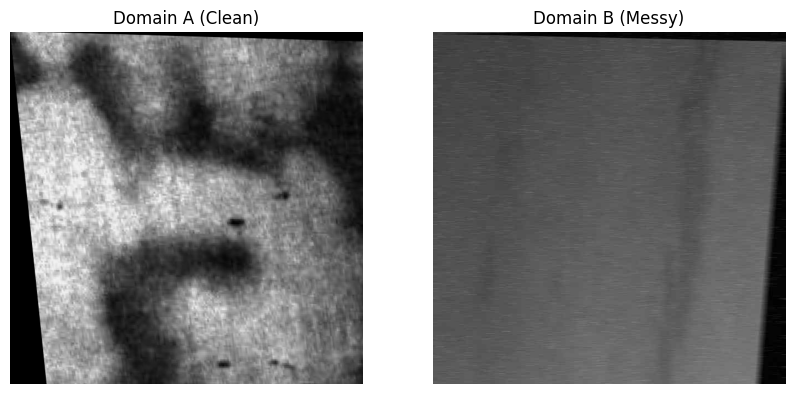

In [3]:
import matplotlib.pyplot as plt
import cv2
import random

def show_random(folder, title):
    imgs = list(Path(folder).iterdir())
    img = cv2.imread(str(random.choice(imgs)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); show_random(DEST_ROOT/"trainA", "Domain A (Clean)")
plt.subplot(1, 2, 2); show_random(DEST_ROOT/"trainB", "Domain B (Messy)")
plt.show()


In [4]:
print("🚀 Training CycleGAN...")

!python train.py \
    --dataroot ./datasets/steel_AB \
    --name steel_AB_cyclegan \
    --model cycle_gan \
    --batch_size 1 \
    --preprocess resize_and_crop \
    --load_size 286 \
    --crop_size 256 \
    --display_freq 200 \
    --print_freq 200 \
    --no_html \
    --n_epochs 20 \
    --n_epochs_decay 20 \
    --direction BtoA \


    


🚀 Training CycleGAN...
----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/steel_AB           	[default: None]
             dataset_mode: unaligned                     
                direction: BtoA                          	[default: AtoB]
             display_freq: 200                           	[default: 400]
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: lsgan                         
                init_gain: 0.02                          
                init_type: normal                        
                 i